9444 Project Notebook<br>
GAN-Based Semantic Segmentation Enhancement for Complex Scenes in ADE20K 

**Yuji Mao z5522942**<br>
**Haitao Wu z5516805**<br>
**Chenlin Li z5527155**<br>
**Junwei Zhang z5448642**<br>
**Zhongtao Du z5504303**<br>

# Introduction

Semantic understanding of visual scenes is one of the biggest enigmas in computer vision. One of the biggest issues with scene comprehension is still scene parsing, which is the process of recognizing and distinguishing objects and other features in an image. Our objective is to comprehend the GAN model as the best option for scene parsing and semantic segmentation. In this study, we used ADE20K, a large-scale image dataset that allows us to evaluate and validate our results, to compare the outcomes of non-deep learning techniques, simple deep convolutional neural network (ConvNet) approaches, and GAN.

# Why ADE20K 

ADE20K is a dataset with densely annotated images, which means every pixel has a semantic label and the labels are diverse and unrestricted [1]. The images in this dataset are meticulously segmented manually, encompassing a wide range of object components, scenes, and categories. Compared to other datasets, ADE20K not only has a large set of classes with condensed and consistent annotations labeled in diverse scenes but also contains independently segmented object instances with associated object parts [1]. According to these outstanding features of ADE20K dataset, it facilitates advancement in highly detailed and contextually accurate scene parsing when dealing with image content removal and scene synthesis.

Other datasets have been addressed because of their limited number of objects in sparely annotated images, and some objects can not be commonly encountered in real-world situations. Moreover, others have a narrow range of object classes and predefined vocabulary, with some of them having noisy labels at object labels, which increases the difficulty of training [1]. As a solution of these challenges noted, ADE20K includes high-resolution imagery with comprehensive annotations and a wide range of scenes. Therefore, scene parsing and instance segmentation as two significant benchmarks is established with ADE20K on pixel-wise scene interpretation, which requires models to have strong capability for better performance in various scenes [2].

In [ ]:
from scipy.io import loadmat
data = loadmat('color150.mat')
print(data.keys())
print(data['colors'])

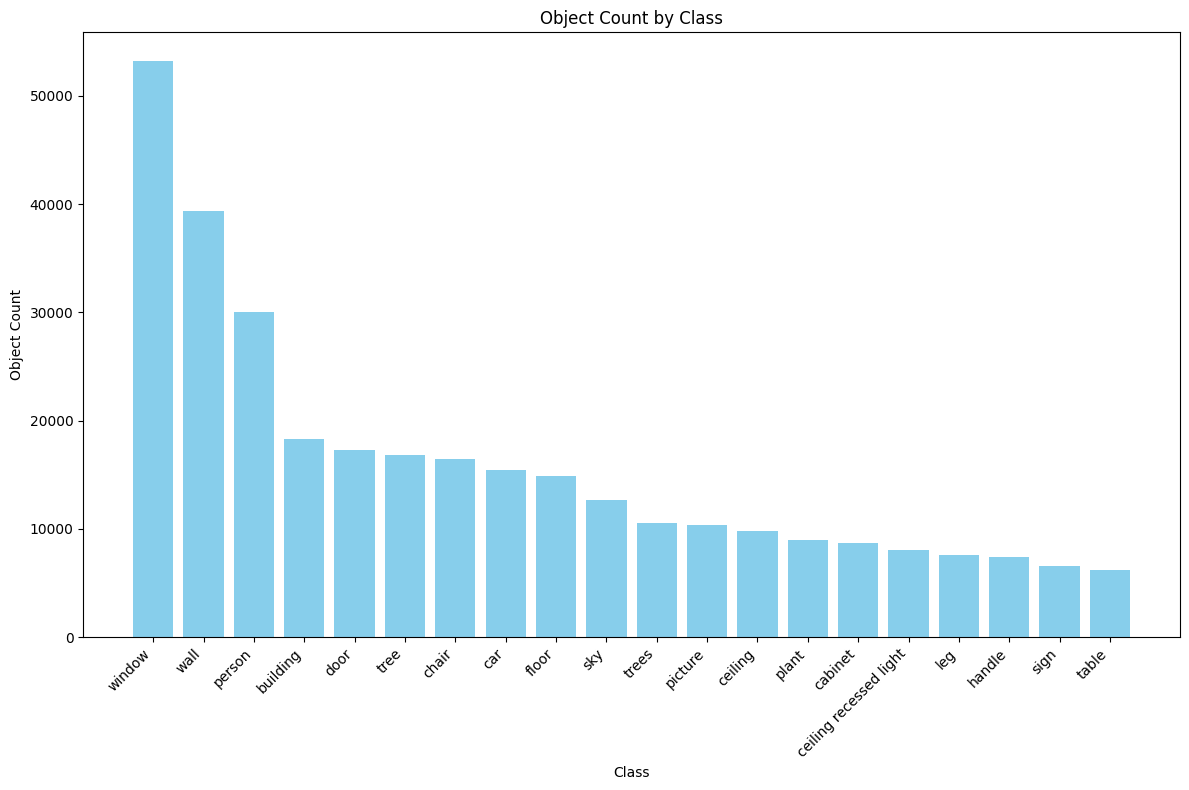

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Class': [
        'window', 'wall', 'person', 'building', 'door', 'tree', 'chair', 'car', 'floor', 'sky', 
        'trees', 'picture', 'ceiling', 'plant', 'cabinet', 'ceiling recessed light', 'leg', 'handle', 'sign', 'table'
    ],
    'Object count': [
        53207, 39322, 30050, 18253, 17272, 16837, 16492, 15431, 14873, 12699, 
        10546, 10397, 9838, 9001, 8709, 8007, 7556, 7378, 6599, 6160
    ]
}

df = pd.DataFrame(data)

df = df.sort_values(by='Object count', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(df['Class'], df['Object count'], color='skyblue')
plt.xlabel('Class')
plt.ylabel('Object Count')
plt.title('Object Count by Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  
plt.show()


# Metric 

IoU and mIoU ：
Intersection over Union (IoU) is a metric used to measure the overlap between two areas, commonly used in computer vision tasks such as object detection and image segmentation. The value of IoU ranges from 0 to 1, where 1 indicates complete overlap and 0 indicates no overlap at all.
IoU is calculated by dividing the area of the intersection of the two regions by the area of their union<br>. The formula i:


$$ IoU = \frac{|A \cap B|}{|A \cup B|} $$

The intersection represents the overlapping part of the two areas, while the union represents the total area covered by both regions (including both the overlapping and non-overlapping parts).<br>
The specific formula for IoU is:

$$ IoU = \frac{\text{Intersection Area}}{\text{Union Area}} $$

Here, the intersection is the overlapping area between the predicted region and the ground truth, and the union is the total area of both.

Mean IoU (mIoU) is the calculated average of multiple categories of IoU used to evaluate the overall performance of the model over the entire image segmentation task. For a scenario with multiple categories, mIoU first calculates the IoU for each category separately and then averages it:

$$ \text{mIoU} = \frac{1}{N} \sum_{i=1}^{N} \text{IoU}_i $$

Where N represents the number of classes, and IoUi represents the IoU of the i class. mIoU is more concerned with the overall performance of the model for all classes than a single IoU.

# Method

To understand the reason for GAN being the best approach for semantic segmentation, we conducted a comparison of the outcomes of non-deep learning techniques, simple deep convolutional neural network (ConvNet) approaches, and GAN on ADE20K. We chose mean Intersection over Union (mIoU) as the metric of comparison, which is calculated by the overlapping region between predicted and ground-trued segmentation divided by the area of union between the two [3]. Given the extensive scale of the ADE20K dataset with over 25,000 annotated images, we opted to train our model using the 150 most frequently annotated classes, ensuring efficient training while maintaining a representative sample of common objects and scene elements.

To understand the reason for GAN being the best approach for semantic segmentation, we conducted a comparison of the outcomes of non-deep learning techniques, simple deep convolutional neural network (ConvNet) approaches, and GAN on ADE20K. We chose mean Intersection over Union (mIoU) as the metric of comparison, which is calculated by the overlapping region between predicted and ground-trued segmentation divided by the area of union between the two [3]. Given the extensive scale of the ADE20K dataset with over 25,000 annotated images, we opted to train our model using the 150 most frequently annotated classes, ensuring efficient training while maintaining a representative sample of common objects and scene elements.

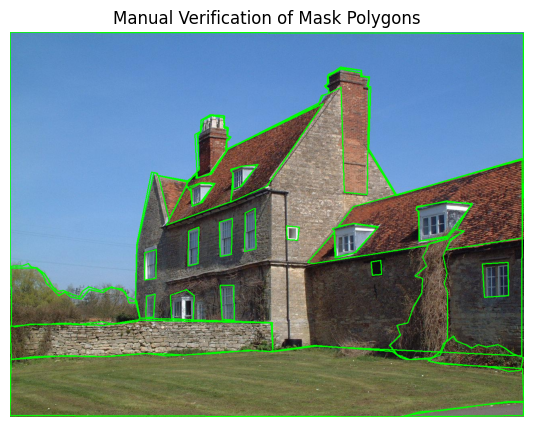

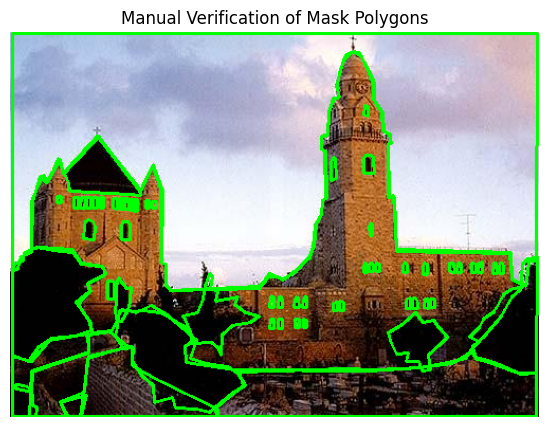

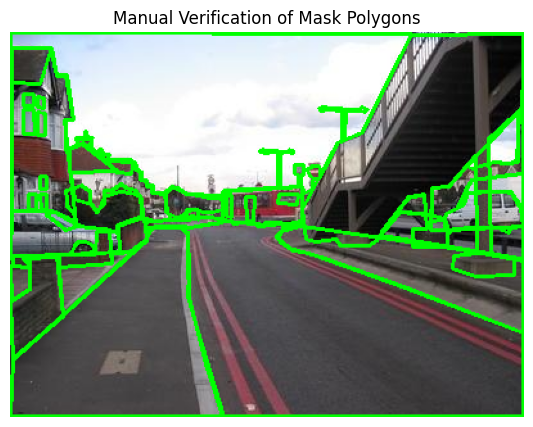

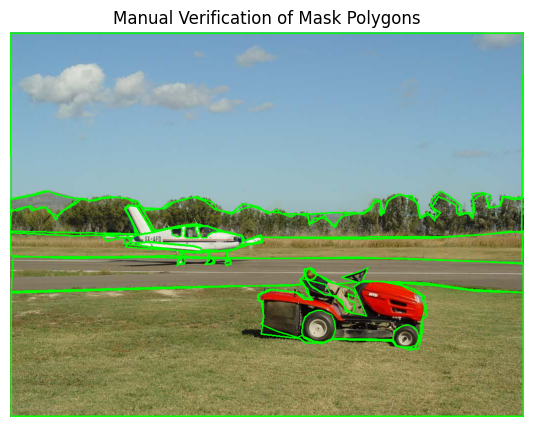

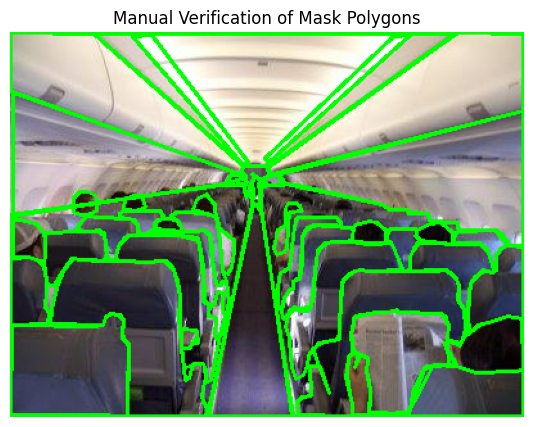

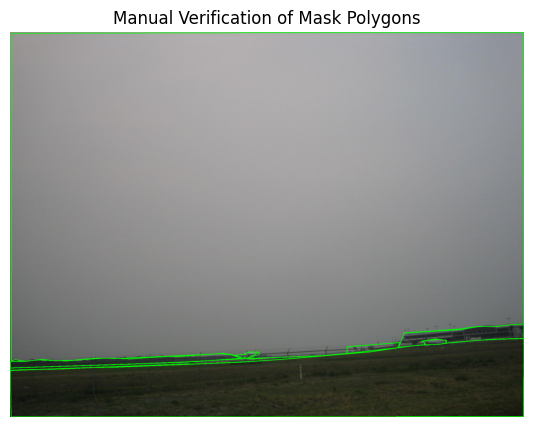

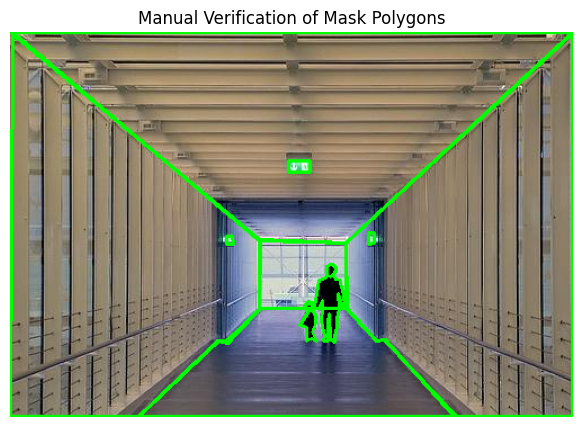

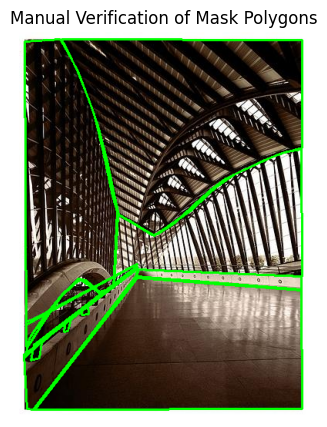

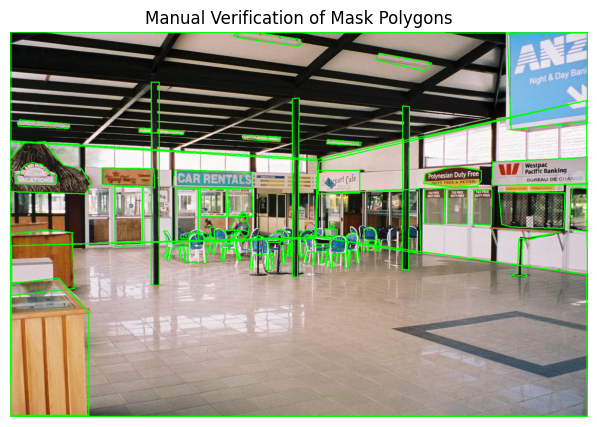

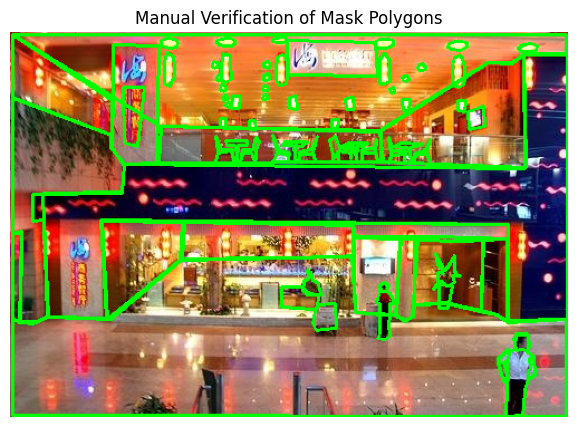

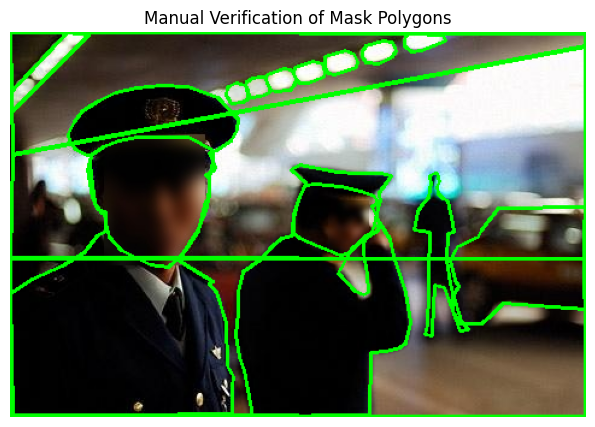

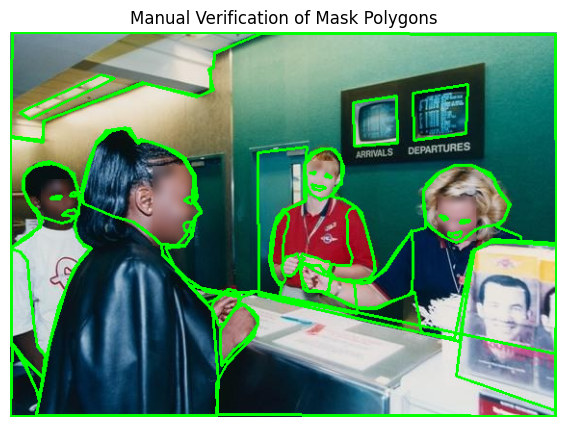

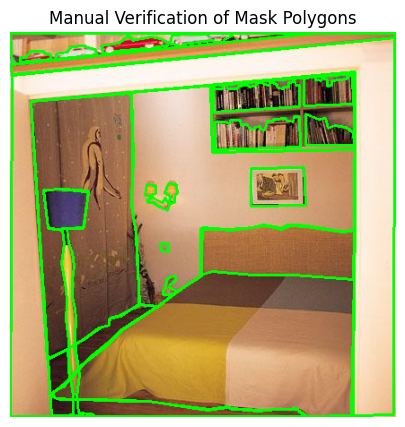

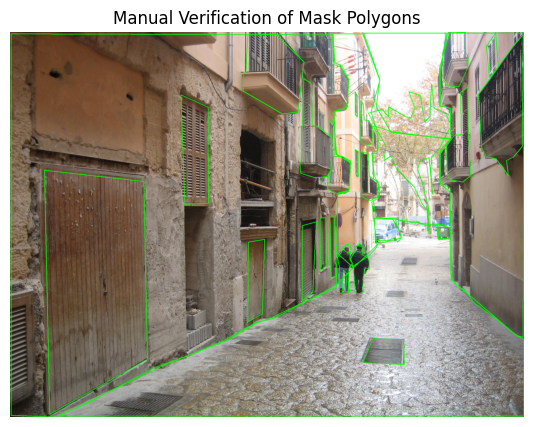

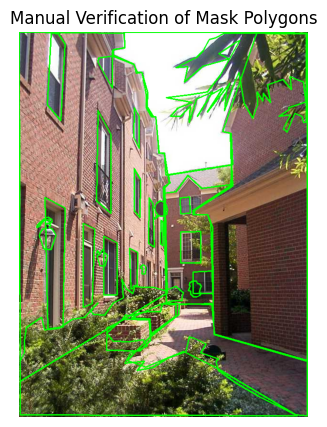

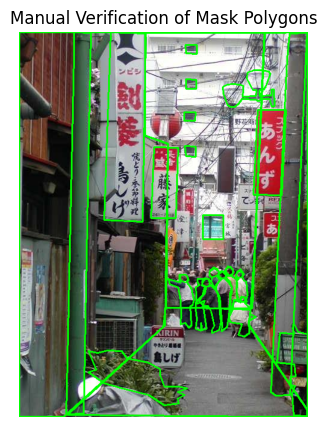

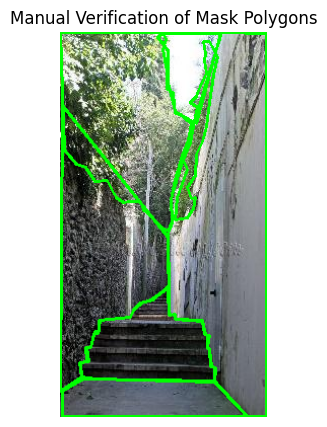

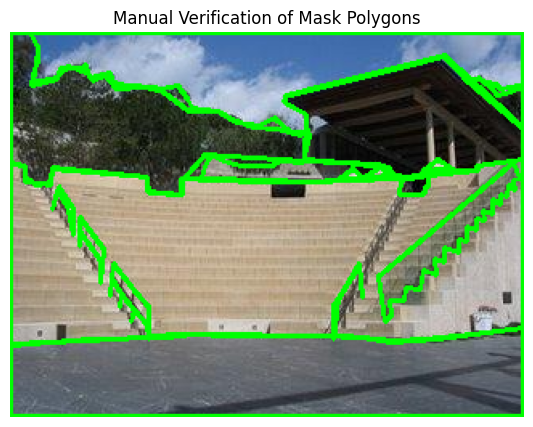

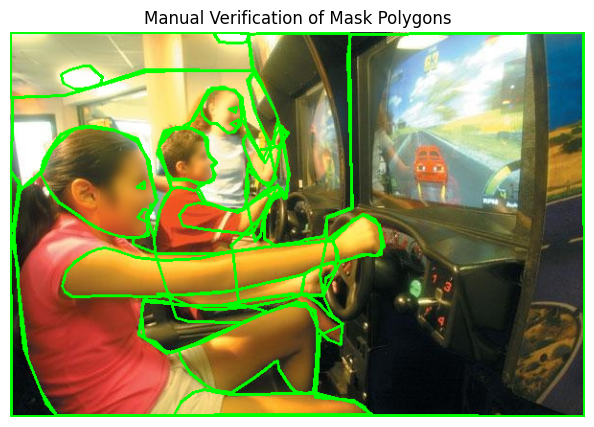

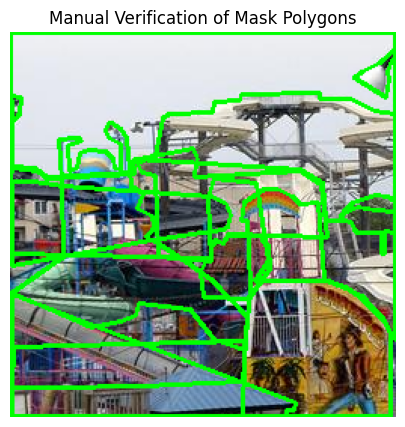

In [24]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image_and_mask(img_dir, ann_dir):
    images = []
    masks = []

    for filename in os.listdir(img_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(img_dir, filename)
            json_filename = filename.replace('.jpg', '.jpg.json')
            json_path = os.path.join(ann_dir, json_filename)

            # load image
            image = cv2.imread(image_path)
            height, width = image.shape[:2]
            mask = np.zeros((height, width), dtype=np.uint8)

            # check if exists
            if os.path.exists(json_path):
                with open(json_path, 'r') as f:
                    annotation = json.load(f)

                # parse annotations to extract points + update mask
                if 'objects' in annotation:
                    for obj in annotation['objects']:
                        if 'points' in obj and 'exterior' in obj['points']:
                            points = np.array(obj['points']['exterior'], dtype=np.int32)
                            
                            points[:, 0] = np.clip(points[:, 0], 0, width - 1)
                            points[:, 1] = np.clip(points[:, 1], 0, height - 1)
                            
                            cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)
                            # print("Polygon points:", points)  

                            cv2.fillPoly(mask, [points], color=255)

                plt.figure(figsize=(10, 5))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title("Manual Verification of Mask Polygons")
                plt.axis("off")
                plt.show()
                
            else:
                print(f"Warning: {json_path} not found, skipping.")

            images.append(image)
            masks.append(mask)

    return images, masks

img_dir = 'ade20k/validation/img'
ann_dir = 'ade20k/validation/ann'

images, masks = load_image_and_mask(img_dir, ann_dir)

Binary Markers unique values: [  0 255]
Binary Ground Truth unique values: [  0 255]


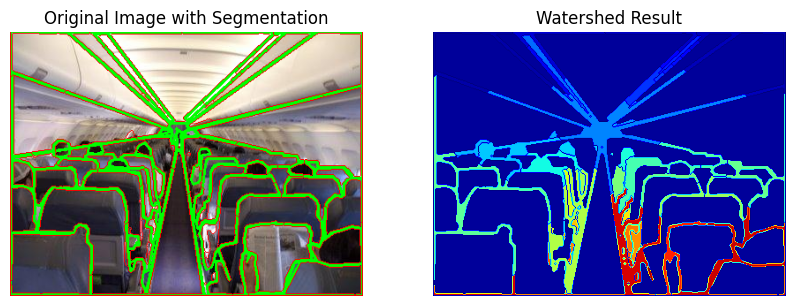

Binary Pixel Accuracy: 0.1973
Binary Mean IoU: 0.1944


In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def compute_gradient(image):
    gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8))
    return gradient

def apply_watershed(image, gradient):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)  # Gaussian blur
    gradient_gray = cv2.cvtColor(gradient, cv2.COLOR_BGR2GRAY) if len(gradient.shape) == 3 else gradient
    _, binary = cv2.threshold(gradient_gray, 65, 255, cv2.THRESH_BINARY)

    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.6 * dist_transform.max(), 255, 0)

    sure_bg = cv2.dilate(binary, np.ones((3, 3), np.uint8), iterations=3)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    return markers

def visualize_result(image, markers):
    image[markers == -1] = [0, 0, 255]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image with Segmentation")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Watershed Result")
    plt.imshow(markers, cmap='jet')
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    # Using the first image and mask
    image = images[4].copy()
    mask = masks[4].copy()  # Ground truth mask

    # Compute gradient and apply watershed
    gradient = compute_gradient(image)
    markers = apply_watershed(image, gradient)

    # Convert markers to binary
    binary_markers = np.where(markers > 1, 255, 0).astype(np.uint8)
    print("Binary Markers unique values:", np.unique(binary_markers))

    # Ensure ground truth is in binary format
    binary_ground_truth = np.where(mask > 0, 255, 0).astype(np.uint8)
    print("Binary Ground Truth unique values:", np.unique(binary_ground_truth))

    # Visualize the segmentation result
    visualize_result(image, markers)

    # Calculate Pixel Accuracy
    pixel_accuracy = np.sum(binary_markers == binary_ground_truth) / len(binary_ground_truth.flatten())
    print(f"Binary Pixel Accuracy: {pixel_accuracy:.4f}")

    # Calculate Mean IoU
    intersection = np.logical_and(binary_markers == 255, binary_ground_truth == 255).sum()
    union = np.logical_or(binary_markers == 255, binary_ground_truth == 255).sum()
    mean_iou = intersection / union if union > 0 else 0
    print(f"Binary Mean IoU: {mean_iou:.4f}")


FCNN<br>
After the watershed segmentation sheds light on separate touching or overlapping objects that treat the image as a topographic surface, we are now shifting the focus to simple deep-learning techniques to improve the performance. We attempted to use Convolutional Networks (CNN) to make up for the defects of watershed transform. Our fully convolutional model’s ability to predict dense outputs from arbitrary-sized inputs, makes it seem to be an ideal model for semantic segmentation especially for this dataset [4]. With an image of input size h * w, we transformed it into a three-dimensional array, multiplying d as the color channel dimension. Replacing fully connected layers with convolutional layers and training them end-to-end allows the network to process images of a wide range of sizes directly from pixels to segmentation outputs using back-propagation [2] With this expectation, we tried to combine layers of the feature ordering and modifying spatial prediction of the output by reducing pooling layer strides and fine-tuning all layers in the whole net for optimization. Although our CNN model eliminates the drawbacks of the watershed model as its over-segmentation and poor noise resilience, it lacks the ability to capture complex distributions and retain details in output quality.  

In [1]:
import torch.nn as nn
import torch.nn.functional as F
# !pip install torchsummary
from torchsummary import summary
import json
import os, csv, scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image, ImageDraw
import os.path as osp
import matplotlib.path as mplPath
import torch

class FCN8s(nn.Module):
    def __init__(self, num_classes, dropout_prop):
        super(FCN8s, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # Ensures output size compatibility
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Additional layers for FCN
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7, padding=3)
        self.dropout6 = nn.Dropout2d(dropout_prop)
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.dropout7 = nn.Dropout2d(dropout_prop)
        self.conv8 = nn.Conv2d(4096, num_classes, kernel_size=1)

        # Transposed convolution layers for upsampling
        self.deconv1 = nn.ConvTranspose2d(num_classes, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, num_classes, kernel_size=32, stride=4, padding=14)

    def forward(self, x):
        pool3 = self.conv1(x)
        pool4 = self.conv2(pool3)
        pool5 = self.conv3(pool4)
        conv5_output = self.conv4(pool5)
        conv5_output = self.conv5(conv5_output)

        # Fully connected layers
        conv6 = F.relu(self.conv6(conv5_output))
        conv6 = self.dropout6(conv6)
        conv7 = F.relu(self.conv7(conv6))
        conv7 = self.dropout7(conv7)
        conv8 = self.conv8(conv7)

        # Upsampling and fusion
        up1 = self.deconv1(conv8)
        up1 = up1 + pool5  # Ensure pool4 has the correct channels

        up2 = self.deconv2(up1)

        up2 = up2 + pool4  # Ensure pool3 has the correct channels

        out = self.deconv3(up2)

        return out

# Instantiate the model
model = FCN8s(num_classes=151, dropout_prop=0.1).to('cuda') # Replace 151 with your desired number of classes
summary(model, input_size=(3, 512, 512))

# input_tensor = torch.randn(1, 3, 512, 512)  # Example input with batch size 1 and 224x224 resolution
# model = FCN8s(num_classes=151, dropout_prop=0.5)

# # Get the output dimension after conv8
# output_tensor = model(input_tensor)
# print(output_tensor.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

In [4]:
def loadImg(img_path):
    return Image.open(img_path)

def loadJson(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data

def createMask(img_size, ann, color):
    mask = Image.new('L', img_size, 0)
    draw = ImageDraw.Draw(mask)

    for obj in ann['objects']:
        class_names = obj['classTitle']
        if class_names in color.keys():
          fill_color = color[class_names]
        else:
          fill_color = color['other']

        exterior_points = [(point[0], point[1]) for point in obj['points']['exterior']]

        draw.polygon(exterior_points, outline=False, fill=fill_color)
    return mask

def createMaskTensor(img_shape, annotations, classes):
    # Create a mask tensor initialized with zeros (background)
    mask_tensor = torch.zeros(img_shape, dtype=torch.int64)

    for obj in annotations['objects']:
        class_name = obj['classTitle']
        if class_name in classes.keys():
            class_value = int(classes[class_name])  # Ensure class number is an integer
        else:
            class_value = 0  # Default background value if class is not recognized

        # Extract exterior points of the polygon
        exterior_points = [(point[0], point[1]) for point in obj['points']['exterior']]
        exterior_points_np = np.array(exterior_points)

        # Create a grid of coordinates (y, x)
        y, x = np.meshgrid(np.arange(img_shape[0]), np.arange(img_shape[1]), indexing='ij')
        points = np.vstack((x.ravel(), y.ravel())).T

        # Check which points in the grid are within the polygon using matplotlib.path
        path = mplPath.Path(exterior_points_np)
        mask = path.contains_points(points).reshape(img_shape)

        # Update the mask tensor with the class number
        mask_tensor[mask] = class_value

    return mask_tensor

def preprocessFile(img_path, json_path, classes, targetSize=(512, 512)):
    img = loadImg(img_path)  # Load the image (as a PIL image or array)
    ann = loadJson(json_path)  # Load the annotation

    # Create the mask using the original image size
    mask = createMaskTensor(img.size[::-1], ann, classes)  # Pass (height, width)

    # Resize the image to the target size
    img = img.resize(targetSize)

    # Convert mask to tensor and resize it using nearest neighbor interpolation
    mask_tensor = torch.from_numpy(np.array(mask)).unsqueeze(0).unsqueeze(0).float()  # Add batch and channel dims
    mask_resized = F.interpolate(mask_tensor, size=targetSize, mode='nearest').squeeze(0).squeeze(0).long()

    return img, mask_resized

def dataTransform(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image)

    return img_tensor

def openClasses():
    classes = {'other': 0}
    with open('object150_info.csv', 'r') as file:
        reader = csv.reader(file)
        i = 0
        for row in reader:
            if i == 0:
                i += 1
                continue
            if ';' in row[-1]:
                tmplst = row[-1].split(';')
                for ele in tmplst:
                    classes[ele] = row[0]
            else:
                classes[row[-1]] = row[0]
    return classes

# Directories and paths (replace these with your actual paths)
training_img_dir = 'ade20k/training 1/img1'
training_json_dir = 'ade20k/training 1/ann1'
validation_img_dir = 'ade20k/validation 1/img1'
validation_json_dir = 'ade20k/validation 1/ann1'


training_img_set = []
training_mask_set = []
validation_img_set = []
validation_mask_set = []

set_name = [[training_img_dir, training_json_dir], [validation_img_dir, validation_json_dir]]

classes = openClasses()
# print(classes)

for idx, ele in enumerate(set_name):
    img_file = os.listdir(ele[0])
    i = 1
    for img in img_file:
        if img == ".DS_Store":
            continue
        img_path = os.path.join(ele[0], img)
        json_path = os.path.join(ele[1], img + '.json')

        img, mask = preprocessFile(img_path, json_path, classes)

        image_tensor, mask_tensor = dataTransform(img), mask

        if idx == 0:
            training_img_set.append(image_tensor)
            training_mask_set.append(mask_tensor)
        else:
            validation_img_set.append(image_tensor)
            validation_mask_set.append(mask_tensor)

        # i += 1
        # if i == 1000:
        #   break
# Batch size for DataLoader
bs = 8

# Training data set
training_images_tensor = torch.stack(training_img_set)
training_masks_tensor = torch.stack(training_mask_set)
training_dataset = TensorDataset(training_images_tensor, training_masks_tensor)
training_data = DataLoader(training_dataset, batch_size=bs, shuffle=True)

# Validation data set
validation_images_tensor = torch.stack(validation_img_set)
validation_masks_tensor = torch.stack(validation_mask_set)
validation_dataset = TensorDataset(validation_images_tensor, validation_masks_tensor)
validation_data = DataLoader(validation_dataset, batch_size=bs, shuffle=False)

def dataset():
    return training_data, validation_data

# Test the DataLoader
print("Testing Training DataLoader...")
for batch_idx, (images_batch, masks_batch) in enumerate(training_data):
    print(f"Batch {batch_idx + 1}")
    print(f"Image batch shape: {images_batch.shape}")  # Expected: [batch_size, 3, 512, 512]
    print(f"Mask batch shape: {masks_batch.shape}")  # Expected: [batch_size, 150, 512, 512]
    break

# for images, masks in training_data:
#     img = images[0].permute(1, 2, 0).cpu().numpy()
#     mask = masks[0].squeeze().cpu().numpy()

#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#     ax[0].imshow(img)
#     ax[0].set_title("Image")

#     ax[1].imshow(mask, cmap='jet')
#     ax[1].set_title("Mask")
#     plt.show()

Testing Training DataLoader...
Batch 1
Image batch shape: torch.Size([1, 3, 512, 512])
Mask batch shape: torch.Size([1, 512, 512])


Training Loop

In [ ]:
training_data, validation_data = dataset()
device = torch.device('cuda')
model = FCN8s(num_classes=151, dropout_prop=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 200

for epoch in range(epochs):
    model.train()
    running_loss = 0
    i = 1
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            for inputs, labels in validation_data:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                print(f"Validation Loss: {loss.item()}")
                break


    for i, (inputs, labels) in enumerate(training_data):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).to(device)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(training_data):.4f}")

# Save the trained model
torch.save(model.state_dict(), 'unet_ade20k_model.pth')
print("Training complete.")

C:\Users\WuHaitao\AppData\Local\Temp\ipykernel_6172\2090179629.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('max_12.pth'))
Clipping 

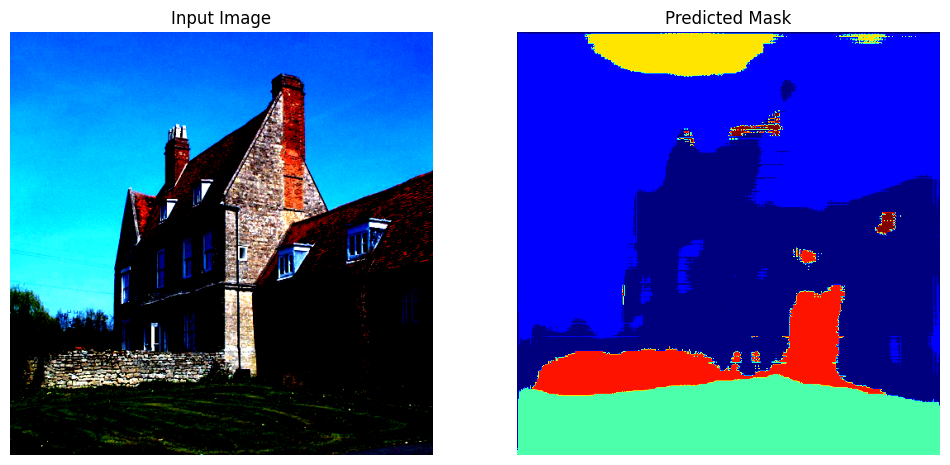

In [13]:
# training_data, validation_data = dataset()
device = torch.device('cuda')
model = FCN8s(num_classes=151, dropout_prop=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


def visualize_output(inputs, outputs, label):
    predictions = torch.argmax(outputs, dim=1)
    
    for i in range(inputs.size(0)):
        image = inputs[i].permute(1, 2, 0).cpu().numpy()
        # iou_lst, m_iou = calculate_miou(label[i], predictions[i], 151)
        # print('miou', m_iou)
        # print('iou list is:', iou_lst)
        loss = criterion(outputs, labels.to(device))
        # print(f"Validation Loss: {loss.item()}")
        mask = predictions[i].cpu().numpy()
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='jet')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

model = FCN8s(num_classes=151, dropout_prop=0).to('cuda')


_, validation_data = dataset()

model.eval()
model.load_state_dict(torch.load('max_12.pth'))
with torch.no_grad():
    for inputs, labels in validation_data:
        inputs = inputs.to('cuda')
        outputs = model(inputs)

        predictions = torch.argmax(outputs, dim=1)

        visualize_output(inputs, outputs, labels)

# GAN
In order to further improve the model’s accuracy, we shifted the focus on Generative Adversarial Network model (abbreviated as GAN) after exploring the traditional thresholding and machining learning. This deep learning model consists of two neural networks, the generator and the discriminator, which are trained in a process of competition. In our model, we utilized a standard 5-layer CNN as the generator and introduced a 5-layer CNN as the discriminator, along with a refined training loop. The generator's objective is to create realistic data samples based on random noise, while the discriminator's job is to distinguish between real data samples from the training set and fabricated data samples generated from the generator. This setup forms an adversarial game where the generator tries to "fool" the discriminator, and the discriminator tries to correctly classify real from generated samples. In the training loop, we calculated the adversarial loss in GAN using binary cross-entropy and the generator’s pixel loss with cross-entropy loss, while evaluating the final image generation quality using mIoU. Under the constant confrontation of generator and discriminator, the model’s performance exceeds that of a single CNN.

In [23]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image, ImageDraw
from pathlib import Path
import torch.nn as nn
from torchsummary import summary
import torchvision
import torch.nn.functional as F
import colorsys
import cv2
import random
import torch.optim as optim
from math import ceil

### Dataload 

This code is primarily used to load images and their corresponding JSON annotation files, generate corresponding masks, preprocess and transform data, and ultimately build PyTorch DataLoaders for training and validation.

### Functionality

- **`fillColor(id, color_set)`**: Iterates over the `color_set` list, finds the element where `id` matches `ele['id']`, and returns the corresponding `color`.

- **`createMask(img_size, ann, color)`**: Creates a mask image based on the image size, annotation data, and color information.
  - Creates a new single-channel ('L' mode) mask image initialized to all black (value 0).
  - Uses `ImageDraw.Draw` to draw polygonal regions on the mask image.
  - Iterates over each object in the annotation, retrieves its category ID, and obtains the corresponding fill color through `fillColor`.
  - Extracts the outer points of the object and draws filled polygons on the mask image.

- **`preprocessFile(img_path, json_path, color)`**: Loads the image and its corresponding JSON annotation, generating the corresponding mask.

- **`dataTransform(image, mask)`**: Preprocesses and transforms the image and mask to fit the model's input requirements.

In [ ]:

def loadImg(img_path):
    return Image.open(img_path)


def loadJson(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data


def fillColor(id, color_set):
    for ele in color_set:
        if id == ele['id']:
            return ele['color']


def createMask(img_size, ann, color):
    mask = Image.new('L', img_size, 0)
    draw = ImageDraw.Draw(mask)
    color_sets = color['classes']  # lst

    for obj in ann['objects']:
        class_id = obj['classId']
        fill_color = fillColor(class_id, color_sets)

        exterior_points = [(point[0], point[1])
                           for point in obj['points']['exterior']]

        draw.polygon(exterior_points, outline=None, fill=fill_color)
    return mask


def preprocessFile(img_path, json_path, color):
    img = loadImg(img_path)
    ann = loadJson(json_path)

    mask = createMask(img.size, ann, color)

    return img, mask


def dataTransform(image, mask):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    mask = mask.resize((512, 512))

    img_tensor = transform(image)
    mask_tensor = torch.tensor(np.array(mask), dtype=torch.long)

    return img_tensor, mask_tensor


def Dataset():
    training_set = training_data
    validation_set = validation_data
    return training_set, validation_set


#
# data_dir = Path(
#     r'C:\Users\Administrator\Desktop\Model(1)\Model')
training_img_dir = 'ade20k/training/img'
training_json_dir = 'ade20k/training/ann'
validation_img_dir = 'ade20k/validation/img'
validation_json_dir = 'ade20k/validation/ann'
meta_dir = 'ade20k/meta.json'

with open(meta_dir, 'r') as file:
    meta = json.load(file)

training_img_set = []
training_mask_set = []
validation_img_set = []
validation_mask_set = []


set_name = [[training_img_dir, training_json_dir],
            [validation_img_dir, validation_json_dir]]


for idx, ele in enumerate(set_name):
    img_file = os.listdir(ele[0])

    # i = 1
    for img in img_file:
        if img == ".DS_Store":  # Skip system files
            continue
        img_path = os.path.join(ele[0], img)
        json_path = os.path.join(ele[1], img + '.json')

        img, mask = preprocessFile(img_path, json_path, meta)

        image_tensor, mask_tensor = dataTransform(img, mask)

        if idx == 0:
            training_img_set.append(image_tensor)
            training_mask_set.append(mask_tensor)
        else:
            validation_img_set.append(image_tensor)
            validation_mask_set.append(mask_tensor)
        # i += 1
        # test the shape of each element
        # print(image_tensor.shape, mask_tensor.shape)
        # i += 1
    # print(i)

# batch_size in dataloader
bs = 1

# training data set
training_images_tensor = torch.stack(training_img_set)
training_masks_tensor = torch.stack(training_mask_set)
training_dataset = TensorDataset(training_images_tensor, training_masks_tensor)
training_data = DataLoader(training_dataset, batch_size=bs, shuffle=False)


# validation data set
validation_images_tensor = torch.stack(validation_img_set)
validation_masks_tensor = torch.stack(validation_mask_set)
validation_dataset = TensorDataset(
    validation_images_tensor, validation_masks_tensor)
validation_data = DataLoader(validation_dataset, batch_size=bs, shuffle=False)

# # test the dataloader
# print("Testing Training DataLoader...")
# for batch_idx, (images_batch, masks_batch) in enumerate(training_data):
#     print(f"Batch {batch_idx + 1}")
#     print(f"Image batch shape: {images_batch.shape}")
#     print(f"Mask batch shape: {masks_batch.shape}")

# for images, masks in training_data:
#     img = images[0].permute(1, 2, 0).cpu().numpy()
#     mask = masks[0].squeeze().cpu().numpy()

#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#     ax[0].imshow(img)
#     ax[0].set_title("Image")

#     ax[1].imshow(mask)
#     ax[1].set_title("Mask")
#     plt.show()

---

### Generator

The generator defines a U-Net variant based on a VGG16 encoder, designed for image segmentation tasks. This model uses an encoder-decoder architecture to extract image features and progressively restore spatial resolution, resulting in a segmentation mask of the same size as the input image.

### Model Functionality

- **Defining the U-Net Model:**
  - **`num_classes=150`**: The number of output classes for the model, set to 150 according to the labels in `adk20e`.
  - **`self.encoder = VGG16()`**: Uses a pre-trained VGG16 as the encoder to extract deep features from the input image.
  - **`in_filters` and `out_filters`:**
    - **`in_filters`**: The number of output channels from each layer of the encoder, specific values are based on the VGG16 implementation.
    - **`out_filters`**: The desired output channels for each layer in the decoder, used to progressively restore spatial resolution.
  - **`self.up_concat5` to `self.up_concat0`:**
    - Each `upUnet` module is responsible for upsampling and concatenating with the corresponding encoder features.
    - Through these modules, the model progressively restores the spatial resolution while combining multi-scale features from the encoder.
  - **`self.final = nn.Conv2d(3, num_classes, kernel_size=1)`**:
    - The final convolutional layer transforms the decoder's output to the desired number of classes.
    - The kernel size of 1 is primarily used to adjust the number of channels without changing spatial dimensions.

- **Forward Propagation Function (`forward`):**
  - **Encoder Outputs**: `self.encoder(inputs)` returns feature maps `p1` to `p6`, each corresponding to different spatial resolutions and semantic levels.
  - **Decoder Process:**
    - **`up_concat5 = self.up_concat5(p5, p6)`**: Combines the 5th-layer encoder feature `p5` with the 6th layer feature `p6`, using the `upUnet` module for upsampling and feature fusion.
    - **Similarly**: Each `upUnet` module combines the previous layer’s output with the corresponding encoder feature, progressively restoring image resolution.
  - **Final Output**: Through `self.final` layer, the final output of the decoder is converted into a segmentation mask with `num_classes` classes.

---


In [17]:

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # input 3*512*512
        self.conv1_1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 64*256*256
        self.conv2_1 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 128*128*128
        self.conv3_1 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 256*64*64
        self.conv4_1 = nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(
            in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(
            in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 512*32*32
        self.conv5_1 = nn.Conv2d(
            in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(
            in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(
            in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 512 * 16 * 16

        self.fc_1 = nn.Linear(512*16*16, 4096)
        self.fc_2 = nn.Linear(4096, 4096)
        self.fc_3 = nn.Linear(4096, 150*8*8)

    def forward(self, x):
        x1 = nn.functional.relu(self.conv1_1(x))
        x1 = nn.functional.relu(self.conv1_2(x1))
        p1 = self.maxpool1(x1)

        x2 = nn.functional.relu(self.conv2_1(p1))
        x2 = nn.functional.relu(self.conv2_2(x2))
        p2 = self.maxpool2(x2)

        x3 = nn.functional.relu(self.conv3_1(p2))
        x3 = nn.functional.relu(self.conv3_2(x3))
        x3 = nn.functional.relu(self.conv3_3(x3))
        p3 = self.maxpool3(x3)

        x4 = nn.functional.relu(self.conv4_1(p3))
        x4 = nn.functional.relu(self.conv4_2(x4))
        x4 = nn.functional.relu(self.conv4_3(x4))
        p4 = self.maxpool4(x4)

        x5 = nn.functional.relu(self.conv5_1(p4))
        x5 = nn.functional.relu(self.conv5_2(x5))
        x5 = nn.functional.relu(self.conv5_3(x5))
        p5 = self.maxpool5(x5)

        x6 = p5.view(p5.size(0), -1)
        x6 = nn.functional.relu(self.fc_1(x6))
        x6 = nn.functional.relu(self.fc_2(x6))
        p6 = self.fc_3(x6)

        p6 = p6.view(p6.size(0), 150, 8, 8)
        return p1, p2, p3, p4, p5, p6

class upUnet(nn.Module):
    def __init__(self, in_size, out_size):
        super(upUnet, self).__init__()
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, inputs1, inputs2):
        output = torch.cat([inputs1, self.up(inputs2)], 1)
        output = self.conv1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.relu(output)
        return output

class Unet(nn.Module):
    def __init__(self, num_classes =150):
        super(Unet, self).__init__()
        self.encoder = VGG16()

        in_filters  = [67, 192, 384, 768, 1024, 662]
        out_filters = [3, 64, 128, 256, 512, 512]

        self.up_concat5 = upUnet(in_filters[5], out_filters[5])
        self.up_concat4 = upUnet(in_filters[4], out_filters[4])
        self.up_concat3 = upUnet(in_filters[3], out_filters[3])
        self.up_concat2 = upUnet(in_filters[2], out_filters[2])
        self.up_concat1 = upUnet(in_filters[1], out_filters[1])
        self.up_concat0 = upUnet(in_filters[0], out_filters[0])

        self.final = nn.Conv2d(3, num_classes, kernel_size=1)

    def forward(self, inputs):
        p1, p2, p3, p4, p5, p6 = self.encoder(inputs)
        
        up5 = self.up_concat5(p5, p6)
        up4 = self.up_concat4(p4, up5)
        up3 = self.up_concat3(p3, up4)
        up2 = self.up_concat2(p2, up3)
        up1 = self.up_concat1(p1, up2)
        up0 = self.up_concat0(inputs, up1)

        output = self.final(up0)

        return output


---

### Discriminator

The discriminator is used in the Generative Adversarial Network (GAN) as the counterpart to the generator (U-Net), working together to distinguish real images from generated ones, assessing the realism of the generated images.

### Model Functionality

- **Defining the Discriminator Class:**
  - **Parameters:**
    - **`input_channels=3`**: The number of channels in the input image, default is 3 (RGB images).
    - **`num_classes=150`**: The number of classes in the segmentation mask, default is 150.
    - **`base_filters=64`**: The number of base convolution filters, determining the number of feature maps in each layer of the network.

  - **Layer Definitions:**
    - **First Convolution Layer (`conv1`):**
      - Input channels are `input_channels + num_classes`, meaning the input image and segmentation mask are concatenated along the channel dimension.
      - Output channels are `base_filters`.
      - Convolution kernel size is 4, with a stride of 2 and padding of 1.
      - **Dropout**: `Dropout(0.3)` is used to prevent overfitting by randomly dropping 30% of neurons.
      
    - **Second Convolution Layer (`conv2`):**
      - Input channels are `base_filters`, output channels are `base_filters * 2`.
      - Uses the same kernel size, stride, and padding as the first layer.
      - **Batch Normalization**: `BatchNorm2d(base_filters * 2)` to accelerate training and stabilize the network.
      - **Dropout**: `Dropout(0.3)`.

    - **Third Convolution Layer (`conv3`):**
      - Input channels are `base_filters * 2`, output channels are `base_filters * 4`.
      - Same parameters as previous layers.
      - **Batch Normalization**: `BatchNorm2d(base_filters * 4)`.

    - **Final Output Layer (`final`):**
      - Input channels are `base_filters * 4`, output channel is 1.
      - Convolution kernel size is 4, with a stride of 1 and padding of 0.

- **Forward Propagation Function (`forward`):**

  - **Inputs:**
    - **`image`**: An RGB image tensor of shape `(N, 3, H, W)`.
    - **`mask`**: A segmentation mask tensor of shape `(N, num_classes, H, W)`.
    - If the `mask` tensor has a dimension of 3 (missing a channel dimension), `unsqueeze(1)` is applied to add the channel dimension, resulting in a shape of `(N, 1, H, W)`.
    - Checks if the height and width of `image` and `mask` match. If they do not match, bilinear interpolation is used to resize the mask to match the image dimensions.
  
  - **Concatenation**: Concatenates `image` and `mask` along the channel dimension to create a tensor `x` of shape `(N, input_channels + num_classes, H, W)`.

  - **Convolution and Activation:**
    - **First Convolution Layer:**
      - Passes through the `conv1` layer and applies Leaky ReLU activation with a negative slope of 0.2.
      - Applies `dropout1`.
    
    - **Second Convolution Layer:**
      - Passes through `conv2`, applies batch normalization (`bn2`), and Leaky ReLU activation.
      - Applies `dropout2`.
    
    - **Third Convolution Layer:**
      - Passes through `conv3`, applies batch normalization (`bn3`), and Leaky ReLU activation.

---



In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self, input_channels=3, num_classes=150, base_filters=64):
        super(Discriminator, self).__init__()

        # First convolution layer
        self.conv1 = nn.Conv2d(input_channels + num_classes,
                               base_filters, kernel_size=4, stride=2, padding=1)
        self.dropout1 = nn.Dropout(0.3)

        # Second convolution layer
        self.conv2 = nn.Conv2d(
            base_filters, base_filters * 2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters * 2)
        self.dropout2 = nn.Dropout(0.3)

        # Third (final) convolution layer before output
        self.conv3 = nn.Conv2d(
            base_filters * 2, base_filters * 4, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 4)

        # Final output layer
        self.final = nn.Conv2d(base_filters * 4, 1,
                               kernel_size=4, stride=1, padding=0)

    def forward(self, image, mask):
        # Ensure mask has a batch dimension if it doesn't
        if len(mask.size()) == 3:
            mask = mask.unsqueeze(1)  # Add channel dimension

        # Resize the mask to match the dimensions of the image if necessary
        if image.size(2) != mask.size(2) or image.size(3) != mask.size(3):
            mask = F.interpolate(mask, size=(image.size(2), image.size(
                3)), mode='bilinear', align_corners=False)

        # Concatenate image and mask along the channel dimension
        x = torch.cat((image, mask), dim=1)

        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.dropout1(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = self.dropout2(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        out = self.final(x)  # Removed sigmoid activation
        return out

# Example usage:
# input_channels = 3 (for RGB image), num_classes = 150 (for segmentation mask)
# image: shape (N, 3, H, W), mask: shape (N, 150, H, W)
# discriminator = Discriminator(input_channels=3, num_classes=150)
# print(discriminator)


---

### Training Loop

- **Data Loading**: Loads the training and validation datasets using a custom Dataset function, verifying the shape of the data.

- **Device Setup**: Detects the available computing device (GPU or CPU) and moves the model to the device.

- **Model Initialization**: Instantiates the U-Net model and loads the pre-trained VGG16 encoder weights to accelerate training and improve model performance.

- **Loss Function and Optimizer**: Defines the cross-entropy loss function and the stochastic gradient descent (SGD) optimizer, setting the number of training epochs.

- **Training Loop**: Performs multiple epochs of training, executing the following for each batch:
  - **Forward Pass**: Computes model predictions.
  - **Loss Calculation**: Calculates the loss between predictions and ground truth.
  - **Backward Pass**: Executes backpropagation to compute gradients.
  - **Parameter Update**: Updates model parameters based on the optimizer.
  - Prints the loss for each batch to monitor training progress.

- **Model Saving**: Saves the trained model weights to a file for future use or deployment.

---

After training on 20,000 samples for 30 epochs with two Nvidia 4090 GPUs, we obtained the following model: `GAN_my_net.pth`.

---


In [ ]:


# Set random seed for reproducibility
seed = 42  # Set seed value
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using multiple GPUs

# Set deterministic mode for cudnn to ensure reproducible results
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

training_data, validation_data = Dataset()

# Initialize models
generator = Unet().to(device)
discriminator = Discriminator(input_channels=3, num_classes=150).to(device)

# Pretrained model paths
generator_pretrained_path = ''  # Path to pretrained generator model
discriminator_pretrained_path = ''  # Path to pretrained discriminator model

# Load pretrained model weights (if available)
if os.path.exists(generator_pretrained_path):  # Check existence using os.path
    generator.load_state_dict(torch.load(generator_pretrained_path))
    print(f"Loaded pre-trained generator weights from {generator_pretrained_path}")

if os.path.exists(discriminator_pretrained_path):  # Check existence using os.path
    discriminator.load_state_dict(torch.load(discriminator_pretrained_path))
    print(f"Loaded pre-trained discriminator weights from {discriminator_pretrained_path}")

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_pixel = nn.CrossEntropyLoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.00002, betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.9, 0.999))

epochs = 10

for epoch in range(epochs):
    print(f'---- Epoch {epoch + 1} ----')
    generator.train()
    discriminator.train()
    running_loss_G = 0.0
    running_loss_D = 0.0

    for i, (images, labels) in enumerate(training_data):
        images = images.to(device)
        labels = labels.to(device)

        optimizer_D.zero_grad()

        fake_masks = generator(images)
        
        if len(labels.size()) == 4 and labels.size(1) == 1:
            labels = labels.squeeze(1)

        # One-hot encode labels
        labels = F.one_hot(labels, num_classes=150).permute(0, 3, 1, 2).float()
        
        real_pred = discriminator(images, labels)
        real_labels = torch.ones_like(real_pred).to(device)
        loss_D_real = criterion_GAN(real_pred, real_labels)

        fake_pred = discriminator(images, fake_masks.detach())
        fake_labels = torch.zeros_like(fake_pred).to(device)
        loss_D_fake = criterion_GAN(fake_pred, fake_labels)

        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        pred_fake = discriminator(images, fake_masks)
        valid_labels = torch.ones_like(pred_fake).to(device)

        loss_G_GAN = criterion_GAN(pred_fake, valid_labels)

        # Convert labels from one-hot to integer format
        labels = labels.argmax(1)  # Select index with maximum value as integer class label
        loss_G_pixel = criterion_pixel(fake_masks, labels)  # Compute cross-entropy loss

        loss_G = loss_G_GAN + 10 * loss_G_pixel
        loss_G.backward()
        optimizer_G.step()

        running_loss_G += loss_G.item()
        running_loss_D += loss_D.item()

        if (i + 1) % 10 == 0:
            print(
                f"Batch {i+1}/{len(training_data)} | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")

    avg_loss_G = running_loss_G / len(training_data)
    avg_loss_D = running_loss_D / len(training_data)
    print(
        f"Epoch {epoch+1}/{epochs} | Avg Loss_D: {avg_loss_D:.4f} | Avg Loss_G: {avg_loss_G:.4f}")

# Save trained generator model weights
torch.save(generator.state_dict(), 'GAN_my_net.pth')
print('Finished Training')


---

### Generating Training Results

Loads the pre-trained U-Net model and performs segmentation predictions on validation images from a specified directory. The segmentation results are mapped to color mask images, saved, and visualized alongside the original images using Matplotlib.

#### Key Functionalities Implemented:

1. **Directory and File Management:**
   - Defines directories for data, image input, and output of segmentation results.
   - Verifies the existence of the input image directory and lists all supported image files.
   - Creates the output directory to store segmentation results.

2. **Model Loading:**
   - Instantiates the U-Net model and transfers it to the available computational device (GPU or CPU).
   - Loads the pre-trained model weights from `GAN_my_net_10.pth` and applies them to the model.
   - Sets the model to evaluation mode to disable training-specific layer behaviors (like Dropout).

3. **Image Preprocessing:**
   - Defines preprocessing transformations, including resizing, conversion to tensor, and normalization.
   - Creates a color mapping table based on the dataset’s class count for visualizing segmentation results.

4. **Batch Processing and Inference:**
   - Divides images into batches (up to 20 images per batch).
   - For each image:
     - Loads and preprocesses the image.
     - Performs forward inference with the U-Net model to generate segmentation masks.
     - Maps the segmentation mask to a color image and saves it to the output directory.
   - At the end of each batch, visualizes the original images and segmentation results using Matplotlib.

5. **Error Handling:**
   - Captures and logs any exceptions that occur during processing to ensure program robustness.

6. **Visualization:**
   - Uses Matplotlib to display segmentation results of each batch, allowing for intuitive evaluation of model performance.

---


C:\Users\WuHaitao\AppData\Local\Temp\ipykernel_6172\1234752759.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(data_dir / 'GAN_my_net_v2

Saved colored segmentation result to D:\BaiduNetdiskDownload\Model(1)\Model\segmentation_results\ADE_val_00000001.png
Saved colored segmentation result to D:\BaiduNetdiskDownload\Model(1)\Model\segmentation_results\ADE_val_00000002.png
Saved colored segmentation result to D:\BaiduNetdiskDownload\Model(1)\Model\segmentation_results\ADE_val_00000003.png
Saved colored segmentation result to D:\BaiduNetdiskDownload\Model(1)\Model\segmentation_results\ADE_val_00000004.png
Saved colored segmentation result to D:\BaiduNetdiskDownload\Model(1)\Model\segmentation_results\ADE_val_00000005.png
Saved colored segmentation result to D:\BaiduNetdiskDownload\Model(1)\Model\segmentation_results\ADE_val_00000006.png
Saved colored segmentation result to D:\BaiduNetdiskDownload\Model(1)\Model\segmentation_results\ADE_val_00000007.png
Saved colored segmentation result to D:\BaiduNetdiskDownload\Model(1)\Model\segmentation_results\ADE_val_00000008.png
Saved colored segmentation result to D:\BaiduNetdiskDown

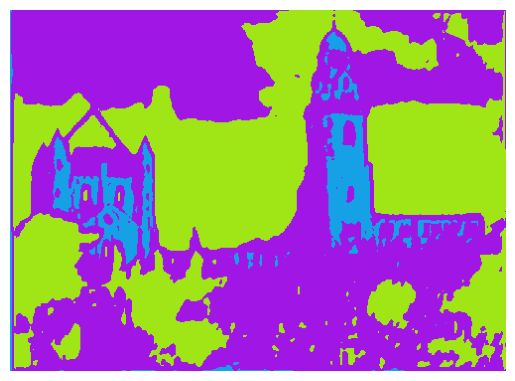

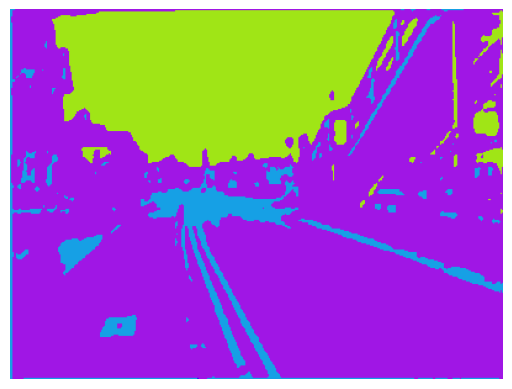

In [44]:


# Set data paths
data_dir = Path(r'D:\BaiduNetdiskDownload\Model(1)\Model')
output_dir = data_dir / 'segmentation_results'
output_dir.mkdir(exist_ok=True)  # Create the output folder for results

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet().to(device)
model.load_state_dict(torch.load(data_dir / 'GAN_my_net_v2.pth'))
model.eval()


# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((512, 512)), # Resize input size to a fixed 512x512
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Define a fixed colormap (ensures colors are consistent across runs)
num_classes = 150 # Assuming there are 150 classes

# Generate a color map using a color wheel, assigning a unique color to each class
colormap = np.zeros((num_classes, 3), dtype=np.uint8)


# Generate different colors using a color wheel, evenly distributing hues over 360°
for i in range(1, num_classes):  # Start from 1 because class 0 is the background, already set to black
    # Vary hue, brightness, and saturation to avoid similar colors
    hue = (i * 40) % 360 / 360.0  # Adjust hue for greater color distinction between classes
    saturation = 0.9  # Increase saturation to prevent dull colors
    brightness = 0.9  # Increase brightness to prevent dark colors
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, brightness)  # Convert HSL to RGB, with high saturation and brightness
    colormap[i] = [int(r * 255), int(g * 255), int(b * 255)]  # Convert to RGB values in the 0-255 range

# Set background color to black
colormap[0] = [0, 0, 0] 

# Process images in the folder in batch
image_folder = data_dir / 'ade20k/validation/img'
for image_path in image_folder.glob('*.jpg'):
    # Load and preprocess the image
    image = Image.open(image_path)
    original_size = image.size # Record the original size of the image
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform inference to get segmentation result
    with torch.no_grad():
        output = model(input_tensor)
    
    # Obtain the segmentation result and resize to the original size
    segmentation_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()

    # Create an empty array to store the color segmentation result
    color_segmentation = np.zeros((segmentation_mask.shape[0], segmentation_mask.shape[1], 3), dtype=np.uint8)

    # Color each class
    for label in range(1, num_classes):  
        color_segmentation[segmentation_mask == label] = colormap[label]

    # Set areas belonging to class 0 directly to black
    color_segmentation[segmentation_mask == 0] = [0, 0, 0]

    # Resize the color segmentation result to the original image size
    color_segmentation = Image.fromarray(color_segmentation).resize(original_size, Image.NEAREST)

    # Save the color segmentation result
    output_path = output_dir / f'{image_path.stem}.png'
    color_segmentation.save(output_path)
    print(f'Saved colored segmentation result to {output_path}')

print("Segmentation completed.")

image_path = output_dir / "ADE_val_00000002.png" 
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")  
plt.show()
image_path = output_dir / "ADE_val_00000003.png" 
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")  
plt.show()

---

### Metric Calculation

Calculates performance metrics for the segmentation task, including:

- **Intersection over Union (IoU)**: Measures the overlap between predicted and true segmentations for each class.

- **Mean Intersection over Union (mIoU)**: The average IoU across all classes.

These metrics help evaluate the quality of segmentation predictions by assessing pixel-level and class-specific accuracy and overlap.

---

In [49]:
import os
import torch
import cv2
import numpy as np

class SegmentationMetric(object):
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = torch.zeros((self.numClass,) * 2)  
        

    def IntersectionOverUnion(self):
        intersection = torch.diag(self.confusionMatrix)
        union = torch.sum(self.confusionMatrix, axis=1) + torch.sum(self.confusionMatrix, axis=0) - intersection
        IoU = intersection / (union + 1e-8)  
        IoU[torch.isnan(IoU)] = float('nan')  
        return IoU

    def meanIntersectionOverUnion(self):
        IoU = self.IntersectionOverUnion()
        mIoU = IoU[IoU < float('inf')].mean() if IoU[IoU < float('inf')].numel() > 0 else float('nan')
        return mIoU

    def genConfusionMatrix(self, imgPredict, imgLabel, ignore_labels):
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        for IgLabel in ignore_labels:
            mask &= (imgLabel != IgLabel)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = torch.bincount(label, minlength=self.numClass ** 2)
        if count.numel() != self.numClass ** 2:
            count = torch.cat([count, torch.zeros(self.numClass ** 2 - count.numel(), dtype=torch.long)])
        
        confusionMatrix = count.view(self.numClass, self.numClass)
        return confusionMatrix

    def addBatch(self, imgPredict, imgLabel, ignore_labels):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel, ignore_labels)  
        return self.confusionMatrix

    def reset(self):
        self.confusionMatrix = torch.zeros((self.numClass, self.numClass))

def process_images(folder1, folder2, ignore_labels=[255], num_class=3):
    metric = SegmentationMetric(num_class)
    
    for filename in os.listdir(folder1):
        imgPredictPath = os.path.join(folder1, filename)
        imgLabelPath = os.path.join(folder2, filename)
        
        if os.path.exists(imgPredictPath) and os.path.exists(imgLabelPath):
            imgPredict = cv2.imread(imgPredictPath, cv2.IMREAD_GRAYSCALE)  
            imgLabel = cv2.imread(imgLabelPath, cv2.IMREAD_GRAYSCALE)
            imgPredict = cv2.Canny(imgPredict, 100, 200)  
            imgLabel = cv2.Canny(imgLabel, 100, 200)      
            imgPredict = torch.tensor(imgPredict).long()
            imgLabel = torch.tensor(imgLabel).long()
            imgPredict = (imgPredict > 0).long()  
            imgLabel = (imgLabel > 0).long()      
            metric.addBatch(imgPredict, imgLabel, ignore_labels)
    
    IoU = metric.IntersectionOverUnion()
    mIoU = metric.meanIntersectionOverUnion()

    return IoU, mIoU


folder1 = 'mask' 
folder2 = 'segmentation_results' 

IoU, mIoU = process_images(folder1, folder2)


print(f"Mean IoU: {mIoU}")


Mean IoU: 0.3300274908542633


# Result

the result are shown as table below:<br>
| Method | mIoU(Mean Intersection over Union) |
|-----|-----|
| Basic Watershed Thresholding | 0.1164 | 
| FCNN | 0.2437 | 
| cGAN | 0.33 | 

Watershed<br>
In our initial approach, the model was highly sensitive to noise and had limited resilience to low-contrast edges. To improve our preset thresholding model’s performance, we attempted to apply Gaussian blur to the current image (kernel size is set to 5X5) to reduce noise interference. To further extract the boundary features, a gradient calculation of the image was carried out and we further converted the gradient map to the grayscale map along with a binary operation of threshold 65 to generate the initial binary map of the advancing region [3]. We have tuned the parameter and threshold of the foreground region after the distance exchange (taking 0.6 times the maximum value of the distance transform) to determine the true foreground. Similarly, an expansion operation is iterated 3 times to determine the background. With these modified steps, we have stabled mean IoU between 0.09 and 0.15, based on the image chosen for testing.



CNN<br>
Our FCN model performs slightly better than watershed with a mean IoU about 0.25. From the image generated, we observed that the predicted mask appears to capture the general structure of the input while it fails to capture details accurately. For instance, the windows and the bed have blurry or non-distinct boundaries, indicating that the model may not be handling edge precision well. These limitations may lead to a lack of sharpness in the segmentation, possible causes could be insufficient training data, incompetent model architecture complexity or the deficit emphasis on specific class features of loss function used for training.

GAN<br>
After fine-tuning the parameters and adjusting the model structure, the mean IoU of GAN yielded around 0.33. Initially, our model had lower mean IoU compared to watershed and CNN, which was only around 0.1. We tackled the issue by adding a 0.3 dropout rate in the discriminator. This approach mitigates overfitting by incorporating dropout, along with adjustments to the generator's learning rate to prevent the discriminator from becoming overly specific and dominant in evaluating the generator's outputs.

# Discussion

Reflecting on our research, we aimed to understand why the GAN model outperformed the FCNN model for semantic segmentation. The primary strength of GANs lies in their adversarial training mechanism. Unlike FCNNs, the generator in a GAN is trained to produce outputs that are indistinguishable from real data, driven by adversarial loss. This process encourages the generator to produce more realistic and consistent segmentation boundaries, thereby improving overall quality. GANs also excel at refining boundary details, as the discriminator enforces high fidelity around object edges and complex structures, resulting in sharper and more accurate segmentation.

Our experiments showed that the GAN model achieved a higher mean Intersection over Union (mIoU) compared to both watershed and FCNN methods, demonstrating the improved ability of GANs to handle complex segmentation tasks. By integrating dropout layers and adjusting the learning rates, we managed to overcome overfitting and balance the adversarial dynamics, which led to enhanced model performance.

Despite these successes, there were still challenges to overcome. The GAN occasionally struggled with distinguishing similar object boundaries, leading to visual inaccuracies. This may have been influenced by the disparity in learning capability between the generator and discriminator, with the discriminator initially dominating, making it hard for the generator to converge effectively. In addition, our computational limitations forced us to use reduced dataset sizes, which may have restricted our model's ability to fully optimize. Nonetheless, the GAN approach significantly improved segmentation quality, confirming its effectiveness over traditional CNN methods for complex scene parsing.

# Conclusion

In this study, we investigated various approaches to scene parsing and semantic segmentation using the ADE20K dataset. Our goal was to compare non-deep learning techniques, traditional convolutional neural networks, and Generative Adversarial Networks (GANs) to determine the most effective method for semantic segmentation.

Our initial traditional approach of watershed transformation demonstrated significant limitations regarding poor handling of low-contrast edges and low noise sensitivity. To overcome these limitations and produce more consistent segmentation results, we trained the convolutional network (FCNN) to capture the general structure of the image with clear high-contrast boundaries. While it has improved results upon the watershed approach, FCNN struggles with boundary precision and complex feature extraction, which leads to further exploration on the deep learning model GAN. 

Our findings suggested that GAN delivers better outcomes regarding semantic segmentation, especially for images and objects with sharp boundaries. Nonetheless, issues like efficient training and computational constraints need to be resolved. Further research could be conducted on optimizing model architecture with a balanced training dynamic. Explorations on more advanced segmentation with more extensive dataset like attention mechanisms or transformer-based models may also lead to enhanced results for challenging scene parsing tasks. 

# Reference

[1] B. Zhou, H. Zhao, X. Puig, S. Fidler, A. Barriuso, and A. Torralba, “Scene Parsing through ADE20K Dataset,” in *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, Honolulu, HI, USA, 2017, pp. 633-641.

[2] B. Zhou, H. Zhao, X. Puig, T. Xiao, S. Fidler, A. Barriuso, and A. Torralba, "Semantic Understanding of Scenes through the ADE20K Dataset," *arXiv preprint* arXiv:1608.05442, 2016. [Online]. Available: https://doi.org/10.48550/arXiv.1608.05442

[3] J.-B. Kim and H.-J. Kim, "Multiresolution-based watersheds for efficient image segmentation," *Pattern Recognition Letters*, vol. 24, no. 1-3, pp. 473-488, 2003. [Online]. Available: https://doi.org/10.1016/S0167-8655(02)00270-2

[4] J. Long, E. Shelhamer, and T. Darrell, "Fully Convolutional Networks for Semantic Segmentation," in *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, Boston, MA, USA, 2015, pp. 3431-3440. [Online]. Available: https://arxiv.org/abs/1411.4038
